In [6]:
# !pip install pyspellchecker
# !pip install spacy

In [7]:
# Import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

from spellchecker import SpellChecker # pyspellchecker library to correct spelling errors.
import string
import spacy

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
nlp = spacy.load('en_core_web_sm')

import re
from gensim.models.word2vec import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

from sklearn.metrics import cohen_kappa_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:

def correct_language(df):
    """
    Use pyspellchecker library to correct spelling errors. Also count the applied corrections and store the matches.
    """
    # Initialize SpellChecker
    spell = SpellChecker()

    # Apply spell-check to each essay in the DataFrame
    df['matches'] = df['essay'].apply(lambda txt: spell.unknown(spell.split_words(txt)))

    # Apply corrections and store the corrected text in a new column
    def apply_correction(txt):
        corrected_text = ' '.join(spell.correction(word) if word in spell else word for word in spell.split_words(txt))
        return corrected_text

    df['corrected'] = df['essay'].apply(apply_correction)

    # Count the number of corrections for each essay
    df['corrections'] = df['matches'].apply(len)

    return df


In [9]:
# read essays from training_set
training_set  = pd.read_csv('./Data/training_set_rel3.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic', 'domain1_score': 'target_score', 'domain2_score': 'topic2_target'})

# apply spelling and grammar corrections
training_set = correct_language(training_set)

training_set.head()

,essay_id,topic,essay,rater1_domain1,rater2_domain1,rater3_domain1,target_score,rater1_domain2,rater2_domain2,topic2_target,...,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6,matches,corrected,corrections
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{caps1, troble, date1's, myspace, organization...",Dear local newspaper I think effects computers...,15
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,NaN,9,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{descion, garrenteed, facebook, adays, locatio...",Dear CAPS1 CAPS2 I believe that using computer...,21
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,NaN,7,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{caps1, caps3, organization1, caps2, caps5, ca...",Dear CAPS1 CAPS2 CAPS3 More and more people us...,8
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,NaN,10,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{person3, percent4, organization1, resturant, ...",Dear Local Newspaper CAPS1 I have found that m...,46
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{caps1, subssiquently, arn't, location2, compu...",Dear LOCATION1 I know having computers has a p...,13


In [10]:
# read essays from validation and test sets

valid_set  = pd.read_csv('./Data/valid_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})
test_set  = pd.read_csv('./Data/test_set.tsv', sep='\t', encoding = "ISO-8859-1")\
            .rename(columns={'essay_set': 'topic'})

combo_set = pd.concat([valid_set, test_set], sort=False)

# apply spelling and grammar corrections
combo_set = correct_language(combo_set)

In [11]:
len(combo_set)

8472

In [12]:
combo_set = pd.concat([combo_set, training_set], sort=False)
combo_set.to_pickle('./SavedModels/combo_set.pkl')

# Generate word embeddings with Word2Vec

In [13]:
# Clean training_set essays before feeding them to the Word2Vec model.
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_essays(essays, logging=False):
    texts = []
    counter = 1
    for essay in essays.corrected:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(essays)))
        counter += 1
        essay = nlp(essay, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in essay if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [14]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', training_set['corrected'].shape)
train_cleaned = cleanup_essays(training_set, logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (12976,)
Processed 2000 out of 12976 documents.
Processed 4000 out of 12976 documents.
Processed 6000 out of 12976 documents.
Processed 8000 out of 12976 documents.
Processed 10000 out of 12976 documents.
Processed 12000 out of 12976 documents.
Cleaned up training data shape:  (12976,)


In [15]:
# Define function to preprocess text for a word2vec model
def cleanup_essay_word2vec(essays, logging=False):
    sentences = []
    counter = 1
    for essay in essays:
        if counter % 2000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(essays)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        essay = nlp(essay, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        essay = " ".join([tok.lemma_.lower() for tok in essay])
        # Split into sentences based on punctuation
        essay = re.split("[\.?!;] ", essay)
        # Remove commas, periods, and other punctuation (mostly commas)
        essay = [re.sub("[\.,;:!?]", "", sent) for sent in essay]
        # Split into words
        essay = [sent.split() for sent in essay]
        sentences += essay
        counter += 1
    return sentences

In [16]:
cleaned_word2vec = cleanup_essay_word2vec(combo_set['corrected'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(cleaned_word2vec))

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Processed 2000 out of 21448 documents
Processed 4000 out of 21448 documents
Processed 6000 out of 21448 documents
Processed 8000 out of 21448 documents
Processed 10000 out of 21448 documents
Processed 12000 out of 21448 documents
Processed 14000 out of 21448 documents
Processed 16000 out of 21448 documents
Processed 18000 out of 21448 documents
Processed 20000 out of 21448 documents
Cleaned up training data size (i.e. number of sentences):  21448


In [17]:
text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(cleaned_word2vec, vector_size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.key_to_index), text_dim))
wordvec_model.save('./SavedModels/wordvec_model')
print("Word2Vec model saved.")

Training Word2Vec model...
Word2Vec model created.
17100 unique words represented by 300 dimensional vectors
Word2Vec model saved.


In [18]:
# Define function to create averaged word vectors given a cleaned text.
def create_average_vec(essay):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in essay.split():
        if word in wordvec_model.wv.key_to_index:
            average = np.add(average, wordvec_model.wv[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

In [19]:
# Create word vectors
cleaned_vec = np.zeros((training_set.shape[0], text_dim), dtype="float32")
for i in range(len(train_cleaned)):
    essay = train_cleaned[i]
    word_vectors = [wordvec_model.wv[word] for word in essay.split() if word in wordvec_model.wv.key_to_index]

    if word_vectors:
        cleaned_vec[i] = np.mean(word_vectors, axis=0)

print("Word vectors for all essays in the training data set are of shape:", cleaned_vec.shape)


Word vectors for all essays in the training data set are of shape: (12976, 300)


# Neural Network Models

In [20]:
# Read generated features from file:
additional_features = pd.read_pickle('./SavedModels/training_features.pkl')

# Use select features from Gini feature importances
feature_list = [
                'word_count',
                'corrections',
                'similarity',
                'token_count',
                'unique_token_count',
                'nostop_count',
                'sent_count',
                'ner_count',
                'comma',
                'question',
                'exclamation',
                'quotation',
                'organization',
                'caps',
                'person',
                'location',
                'money',
                'time',
                'date',
                'percent',
                'noun',
                'adj',
                'pron',
                'verb',
                'cconj',
                'adv',
                'det',
                'propn',
                'num',
                'part',
                'intj'
                ]

additional_features = additional_features[feature_list]

stdscaler = StandardScaler()
additional_features = stdscaler.fit_transform(additional_features)
additional_features.shape

(12976, 31)

In [21]:
# Combine topic number, target score, additional features and cleaned word vectors
all_data = pd.concat([training_set[['topic','target_score']], pd.DataFrame(additional_features), pd.DataFrame(cleaned_vec)], axis=1)
all_data.shape

(12976, 333)

In [22]:
# DataFrame used to pass original values through train_test_split
scores = all_data[['topic', 'target_score']].reset_index()

# Rescale target_score (essay grades) in range 0 - 60:
scaler = MinMaxScaler((0,10))

In [23]:
# Rescale and assign target variable y
scaled = []
for topic in range(1,9):
    topic_scores = scores[scores['topic'] == topic]['target_score'].to_frame()
    s = (scaler.fit_transform(topic_scores).reshape(-1))
    scaled = np.append(scaled, s)

scores['scaled'] = scaled

""" for regression"""
y = scores['scaled'].to_frame()

# Features
X = all_data.drop(['topic', 'target_score'], axis=1)

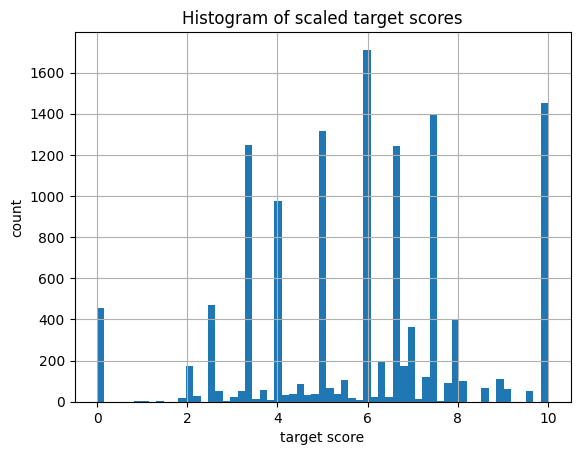

In [24]:
# score histogram
y.hist(bins=61)
plt.title('Histogram of scaled target scores')
plt.xlabel('target score')
plt.ylabel('count')
plt.savefig('./images/image6.png', dpi=300)
plt.show()

In [25]:
# Data to be split
X_train, X_test, y_train, y_test, scores_train, scores_test = \
        train_test_split(
                X,
                y,
                scores,
                test_size=0.2,
                random_state=26
                )

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))
print('scores_train size: {}'.format(scores_train.shape))
print('scores_test size: {}'.format(scores_test.shape))

X_train size: (10380, 331)
X_test size: (2596, 331)
y_train size: (10380, 1)
y_test size: (2596, 1)
scores_train size: (10380, 4)
scores_test size: (2596, 4)


In [26]:
output_dim = y.shape[1]
input_dim = X.shape[1]
dropout = 0.2

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(14, activation='relu', kernel_initializer='he_normal', input_dim=input_dim))

        model.add(Dropout(dropout))
                                               # Regression:
        model.add(Dense(output_dim))

    return model

In [27]:
# Using MLP in kernel for speed
model = build_model('mlp')
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                4648      
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 15        
                                                                 
Total params: 4663 (18.21 KB)
Trainable params: 4663 (18.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
# Compile the model with a specified learning rate
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error'])

In [31]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                4648      
                                                                 
 dropout (Dropout)           (None, 14)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 15        
                                                                 
Total params: 4663 (18.21 KB)
Trainable params: 4663 (18.21 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
# Define number of epochs
epochs = 150

# Fit the model to the training data
estimator = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0)

In [33]:
y_pred = pd.DataFrame(model.predict(X_test).reshape(-1))

82/82 [==============================] - 0s 2ms/step


In [34]:
"""Reverse scaling back to original target score scales"""

# Merge results
results = scores_test.reset_index(drop=True)\
                    .join(y_pred)\
                    .rename(columns={0:'y_pred'})\
                    .sort_values(by='topic')\
                    .reset_index(drop=True)
results.head()

,index,topic,target_score,scaled,y_pred
0,1751,1,10,8.0,7.404946
1,1075,1,12,10.0,8.706494
2,383,1,10,8.0,7.701580
3,706,1,10,8.0,7.681396
4,831,1,10,8.0,7.813874


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

score_df = results.groupby('topic')['target_score'].agg(['min', 'max'])
score_ranges = list(zip(score_df['min'], score_df['max']))

y_p_list = []
y_t_list = []

for topic in range(1, 9):
    scaler = MinMaxScaler(score_ranges[topic-1])
    
    scaled_pred = results[results.topic == topic]['y_pred'].to_frame()
    y_pred_shrunk = scaler.fit_transform(scaled_pred).round(0).astype('int')
    
    scaled_true = results[results.topic == topic]['scaled'].to_frame()
    y_true_shrunk = scaler.fit_transform(scaled_true).round(0).astype('int')
    
    y_p_list.extend(np.squeeze(np.asarray(y_pred_shrunk)))
    y_t_list.extend(np.squeeze(np.asarray(y_true_shrunk)))

# Convert lists to Pandas Series
y_p_df = pd.Series(y_p_list)
y_t_df = pd.Series(y_t_list)

# Append to results df
results['pred'] = y_p_df
results['y_true'] = y_t_df
results.head()

,index,topic,target_score,scaled,y_pred,pred,y_true
0,1751,1,10,8.0,7.404946,10,10
1,1075,1,12,10.0,8.706494,11,12
2,383,1,10,8.0,7.701580,10,10
3,706,1,10,8.0,7.681396,10,10
4,831,1,10,8.0,7.813874,10,10


In [36]:
k = cohen_kappa_score(results.pred, results.target_score, weights='quadratic')
print('Combined essay kappa score: {:.4f}'.format(k))

Combined essay kappa score: 0.9760


In [37]:
# Save the trained model
model.save('./SavedModels/essay_score_model.h5')

c:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
